In [1]:
!pip install xskillscore

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof
import utils
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import transforms
from xskillscore import rmse

In [2]:
test_Y = xr.open_dataset('outputs_ssp245.nc').compute()
test_Y

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 86, member: 3)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
    quantile                   float64 0.9
  * member                     (member) int64 1 2 3
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 0.1953 ... -0...
    tas                        (member, time, lat, lon) float32 1.601 ... 5.677
    pr                         (member, time, lat, lon) float32 9.877e-09 ......
    pr90                       (member, time, lat, lon) float64 -1.104e-07 .....

In [3]:
#extract each actual y variables
tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

In [4]:
#extract the predicted data
tas = xr.open_dataset('xgboost_predicted_tas.nc').compute()
dtr = xr.open_dataset('xgboost_predicted_dtr.nc').compute()
pr = xr.open_dataset('xgboost_predicted_pr.nc').compute()
pr90 = xr.open_dataset('xgboost_predicted_pr90.nc').compute()

In [5]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])
def get_rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))
def rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

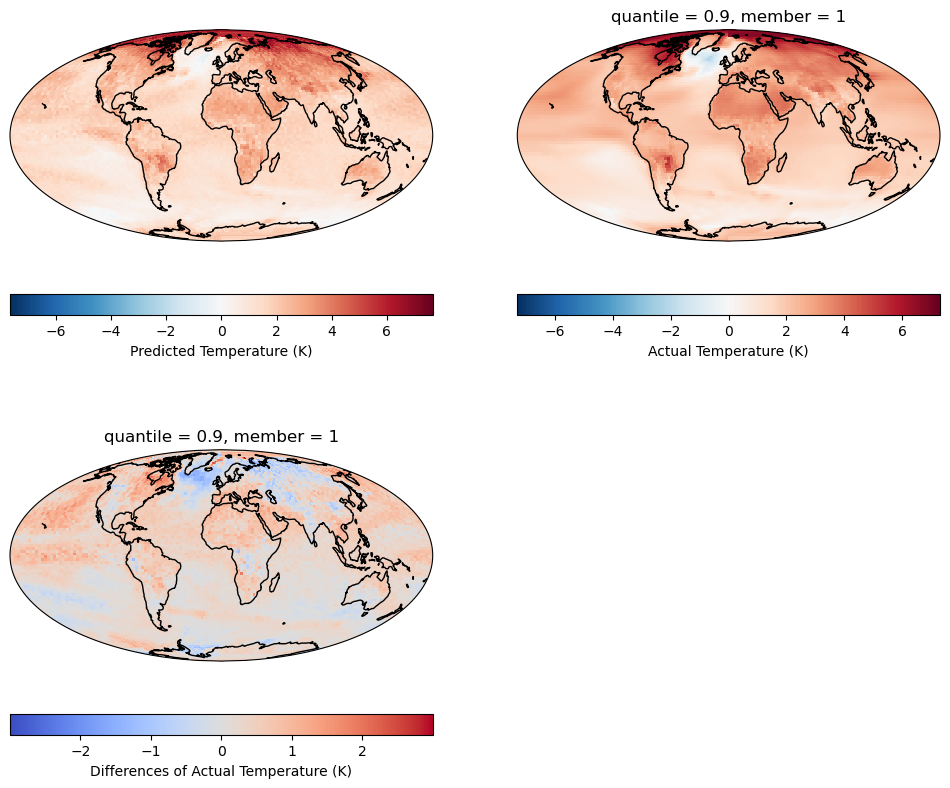

In [6]:
#getting plot for the predicted temperature
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
tas['tas'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the actual temperature
plt.subplot(222,projection=ccrs.Mollweide())
test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the differences
diff_tas = test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']) - tas['tas'].sel(time=slice(2080, 2100)).mean(['time'])
plt.subplot(223, projection=ccrs.Mollweide())
diff_tas.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()

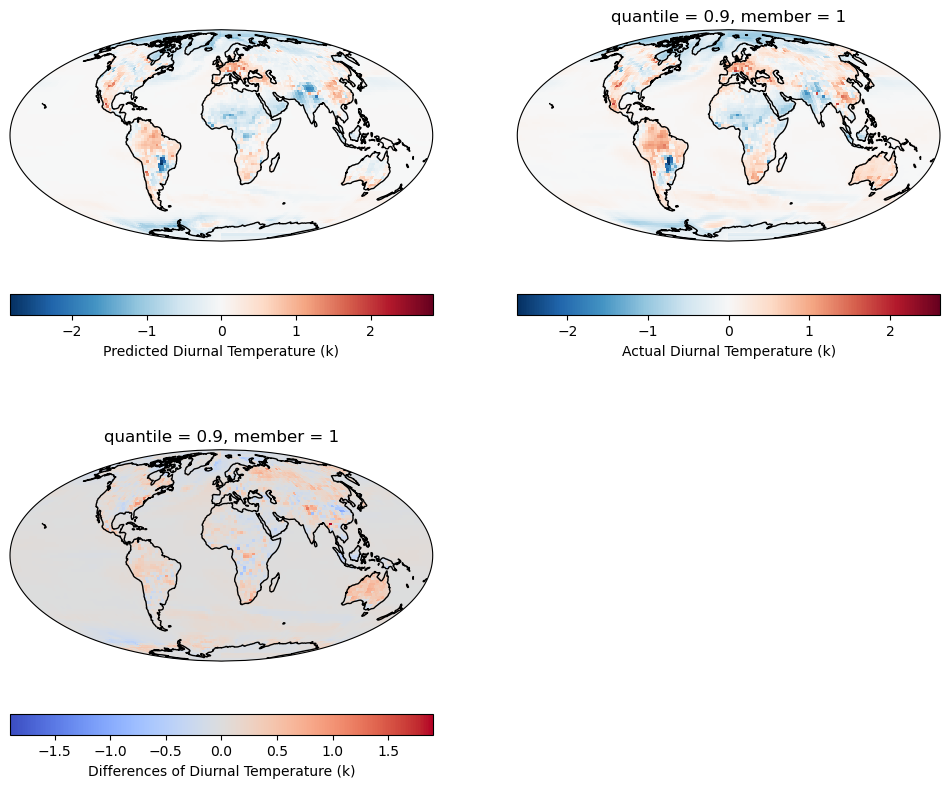

In [7]:
#getting plot for the predicted dtr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
dtr['diurnal_temperature_range'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual dtr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs differences between actual and predicted dtr
diff_dtr = test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']) - dtr["diurnal_temperature_range"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_dtr.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

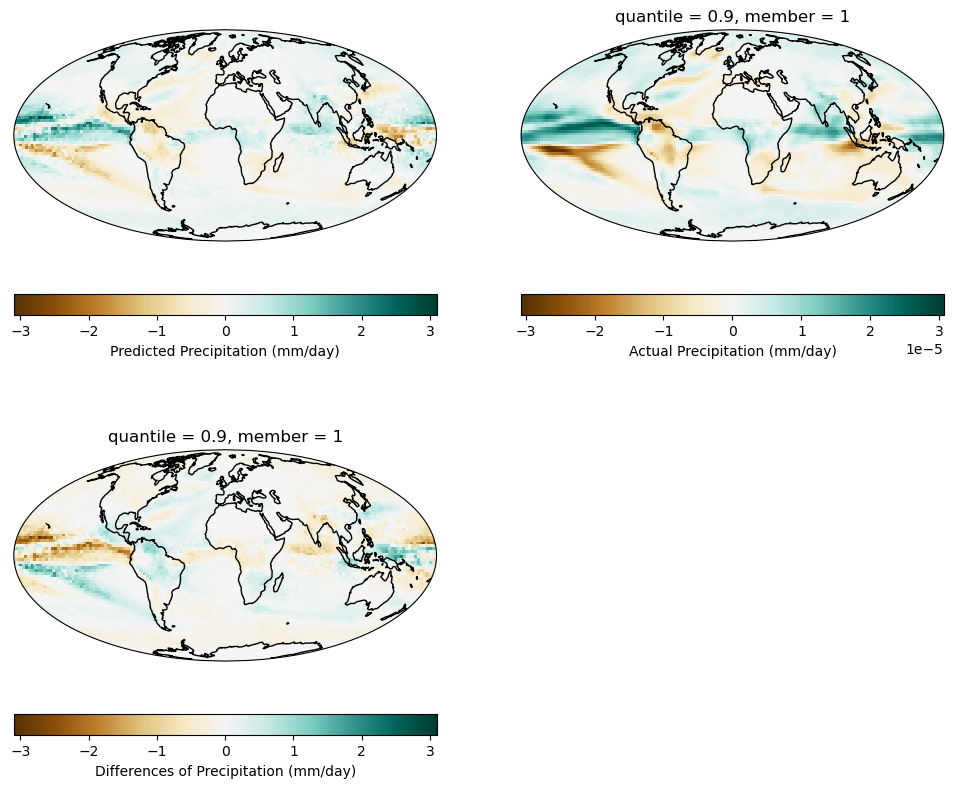

In [8]:
#getting plot for the predicted pr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
pr['pr'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr
diff_pr = test_Y["pr"].sel(time=slice(2080,2100),member=1).mean(['time']) - pr["pr"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

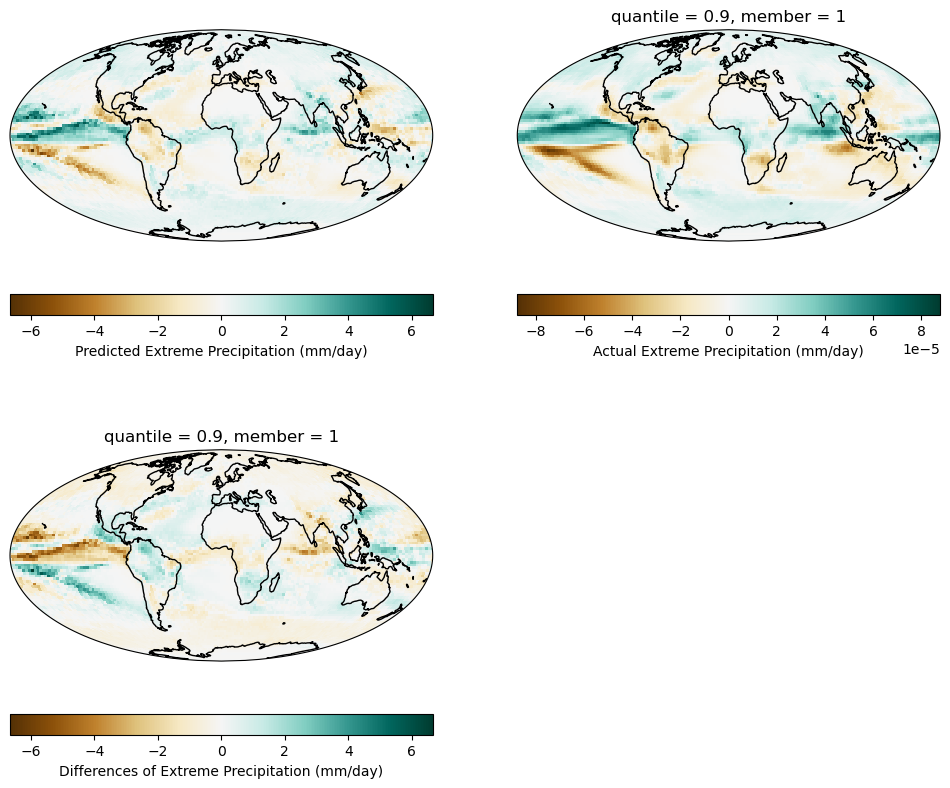

In [9]:
# getting plot for the predicted pr90
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
pr90['pr90'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG",transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr90

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr90'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG",transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr90
diff_pr = test_Y["pr90"].sel(time=slice(2080,2100),member=1).mean(['time']) - pr90["pr90"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [10]:
#calculate the rmse between actual y and predict y for tas
print('RMSE score of tas')
print(f"RMSE of 2050: {rmse(tas_truth[35],tas['tas'][35])}")
print(f"RMSE of 2100: {rmse(tas_truth[85],tas['tas'][85])}")
print(f"RMSE of 2045-2054: {rmse(tas_truth[30:40], tas['tas'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(tas_truth[75:], tas['tas'][75:])}")
print(f"RMSE: {rmse(tas_truth[35:], tas['tas'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for dtr
print('RMSE score of dtr')
print(f"RMSE of 2050: {rmse(dtr_truth[35],dtr['diurnal_temperature_range'][35])}")
print(f"RMSE of 2100: {rmse(dtr_truth[85],dtr['diurnal_temperature_range'][85])}")
print(f"RMSE of 2045-2054: {rmse(dtr_truth[30:40], dtr['diurnal_temperature_range'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(dtr_truth[75:], dtr['diurnal_temperature_range'][75:])}")
print(f"RMSE: {rmse(dtr_truth[35:], dtr['diurnal_temperature_range'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for pr
print('RMSE score of pr')
print(f"RMSE of 2050: {rmse(pr_truth[35],pr['pr'][35])}")
print(f"RMSE of 2100: {rmse(pr_truth[85],pr['pr'][85])}")
print(f"RMSE of 2045-2054: {rmse(pr_truth[30:40], pr['pr'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(pr_truth[75:], pr['pr'][75:])}")
print(f"RMSE: {rmse(pr_truth[35:], pr['pr'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for pr90
print('RMSE score of pr90')
print(f"RMSE of 2050: {rmse(pr90_truth[35],pr90['pr90'][35])}")
print(f"RMSE of 2100: {rmse(pr90_truth[85],pr90['pr90'][85])}")
print(f"RMSE of 2045-2054: {rmse(pr90_truth[30:40], pr90['pr90'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(pr90_truth[75:], pr90['pr90'][75:])}")
print(f"RMSE: {rmse(pr90_truth[35:], pr90['pr90'][35:])}")
print("\n")

RMSE score of tas
RMSE of 2050: 0.4488149095905834
RMSE of 2100: 0.5617271289940968
RMSE of 2045-2054: 0.46201041587923675
RMSE of 2090-2100: 0.5720017097720145
RMSE: 0.5825662860505214


RMSE score of dtr
RMSE of 2050: 0.15357674557218007
RMSE of 2100: 0.15641673015801905
RMSE of 2045-2054: 0.1565113062970513
RMSE of 2090-2100: 0.17396747830362688
RMSE: 0.16584697222187075


RMSE score of pr
RMSE of 2050: 0.6424748956390449
RMSE of 2100: 0.6189208746050394
RMSE of 2045-2054: 0.6434748155993829
RMSE of 2090-2100: 0.586457787368213
RMSE: 0.6139101128780982


RMSE score of pr90
RMSE of 2050: 1.5720958921281627
RMSE of 2100: 1.7770980836531
RMSE of 2045-2054: 1.698187337505896
RMSE of 2090-2100: 1.6517683557949936
RMSE: 1.6985066232914519




In [11]:
#calculate the rmse for the last 20 years
tas_truth2=tas_truth[-20:].mean(dim="time")
pr_truth2=pr_truth[-20:].mean(dim="time")
pr90_truth2=pr90_truth[-20:].mean(dim="time")
dtr_truth2=dtr_truth[-20:].mean(dim="time")

print(f"RMSE for tas: {get_rmse(tas_truth2, tas['tas'][-20:]).data}")
print(f"RMSE for dtr: {get_rmse(dtr_truth2, dtr['diurnal_temperature_range'][-20:]).data}")
print(f"RMSE for pr: {get_rmse(pr_truth2, pr['pr'][-20:]).data}")
print(f"RMSE for pr90: {get_rmse(pr90_truth2, pr90['pr90'][-20:]).data}")

RMSE for tas: 0.623807966709137
RMSE for dtr: 0.12112070620059967
RMSE for pr: 0.2518422188747127
RMSE for pr90: 0.6633122454164917


In [12]:
test_Y["pr"] *= 86400
test_Y["pr90"] *= 86400

In [13]:
from xskillscore import rmse
weights = np.cos(np.deg2rad(test_Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=test_Y.lon)

In [14]:
#get nrmse for tas
NRMSE_tas = rmse(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time'), 
                               tas['tas'].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_tas

<xarray.DataArray ()>
array(0.22726258)
Coordinates:
    quantile  float64 0.9

In [15]:
#get nrmse for dtr
NRMSE_dtr = rmse(test_Y.mean('member')["diurnal_temperature_range"].sel(time=slice(2080, None)).mean('time'), 
                               dtr["diurnal_temperature_range"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_dtr

<xarray.DataArray ()>
array(10.521482)
Coordinates:
    quantile  float64 0.9

In [16]:
#get nrmse for pr
NRMSE_pr = rmse(test_Y.mean('member')["pr"].sel(time=slice(2080, None)).mean('time'), 
                               pr["pr"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')["pr"].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_pr

<xarray.DataArray ()>
array(4.01149417)
Coordinates:
    quantile  float64 0.9

In [17]:
#get nrmse pr90
NRMSE_pr90 = rmse(test_Y.mean('member')["pr90"].sel(time=slice(2080, None)).mean('time'), 
                               pr90["pr90"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')["pr90"].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_pr90

<xarray.DataArray ()>
array(4.7912856)
Coordinates:
    quantile  float64 0.9

In [18]:
#creating dataframe for NRMSE/spatial score
di_NRMSE = {'tas': [NRMSE_tas.data], 'diuranl_temperature_range': [NRMSE_dtr.data],'pr':[NRMSE_pr.data],'pr90':[NRMSE_pr90.data]}
NRMSE=pd.DataFrame(data=di_NRMSE,index=['XGBoost'])
NRMSE

,tas,diuranl_temperature_range,pr,pr90
XGBoost,0.22726257739965686,10.521482003194299,4.011494170965474,4.791285601651553


In [19]:
#get r2e for tas
R2E_tas = get_rmse(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None))), 
                                global_mean(tas['tas'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time')).data)
R2E_tas

<xarray.DataArray 'tas' ()>
array(0.13668759)
Coordinates:
    quantile  float64 0.9

In [20]:
#get r2e for dtr
R2E_dtr = get_rmse(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None))), 
                                global_mean(dtr['diurnal_temperature_range'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None)).mean('time')).data)
R2E_dtr

<xarray.DataArray 'diurnal_temperature_range' ()>
array(2.89476925)
Coordinates:
    quantile  float64 0.9

In [21]:
#get r2e for pr
R2E_pr = get_rmse(global_mean(test_Y.mean('member')['pr'].sel(time=slice(2080, None))), 
                                global_mean(pr['pr'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['pr'].sel(time=slice(2080, None)).mean('time')).data)
R2E_pr

<xarray.DataArray 'pr' ()>
array(0.38505347)
Coordinates:
    quantile  float64 0.9

In [22]:
#get r2e for pr90
R2E_pr90 = get_rmse(global_mean(test_Y.mean('member')['pr90'].sel(time=slice(2080, None))), 
                                global_mean(pr90['pr90'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['pr90'].sel(time=slice(2080, None)).mean('time')).data)
R2E_pr90

<xarray.DataArray 'pr90' ()>
array(0.37453142)
Coordinates:
    quantile  float64 0.9

In [23]:
#creating dataframe for R2E/global score
di_R2E = {'tas': [R2E_tas.data], 'diuranl_temperature_range': [R2E_dtr.data],'pr':[R2E_pr.data],'pr90':[R2E_pr90.data]}
R2E=pd.DataFrame(data=di_R2E,index=['XGBoost'])
R2E

,tas,diuranl_temperature_range,pr,pr90
XGBoost,0.13668758844074755,2.8947692529238123,0.3850534747371847,0.3745314178670189


In [24]:
#combined global and spatial to get the total
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E],keys=['Spatial', 'Global', 'Total']).round(3)
combined_df

,,tas,diuranl_temperature_range,pr,pr90
Spatial,XGBoost,0.22726257739965686,10.521482003194299,4.011494170965474,4.791285601651553
Global,XGBoost,0.13668758844074755,2.8947692529238123,0.3850534747371847,0.3745314178670189
Total,XGBoost,0.910701,24.995328,5.936762,6.663943
